# Running GNN on real-world tracked data

In [1]:
%load_ext autoreload
%autoreload 2

from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.gnn import train_rules_gnn, debug_result2prediction, load_model
from collab_env.gnn.gnn_definition import GNN
from collab_env.gnn.utility import dataset2testloader
from collab_env.sim.boids_gnn_temp.animal_simulation import  static_visualize_2sets
import matplotlib.pyplot as plt
from rich import print
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from tqdm.notebook import tqdm
from typing import List, Tuple
from pathlib import Path
from loguru import logger
import pickle
%matplotlib inline

device = torch.device("cpu")

## Current format consumed by the GNN

In [4]:
boid_dummy_data_fn = expand_path(
    "simulated_data/runpod/boid_single_species_basic.pt",
    get_project_root(),
)

boid_dummy_ds = torch.load(boid_dummy_data_fn, weights_only = False)
print(type(boid_dummy_ds))
print(f"Length of boid_dummy_ds: {len(boid_dummy_ds)}")
for i in range(3):
    p, sp = boid_dummy_ds[i]    
    print(f"i={i}, p.shape: {p.shape}, sp.shape: {sp.shape}")

<class 'collab_env.sim.boids_gnn_temp.animal_simulation.AnimalTrajectoryDataset'>

Length of boid_dummy_ds: 1000

i=0, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=1, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=2, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

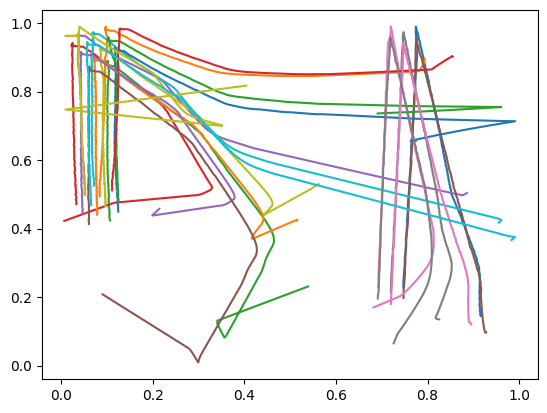

In [5]:
plt.figure()
plt.plot(p[..., 0], p[..., 1])
plt.show()

## The Data

In [6]:
def regular_interpolate(s: pd.DataFrame, **kwargs):
    """
    Interpolate a series with a regular grid.
    """

    ind_min, ind_max = s.index.min(), s.index.max()
    return s.reindex(range(ind_min, ind_max + 1)).interpolate(**kwargs)

In [27]:
ALL_TRACKS_LIST = (
    # './data/tracks/from_processed/2023_11_05-session_0001/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2023_11_05-session_0002/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2023_11_26-session_0001/aligned_frames/rgb_1/rgb_1_tracks.csv',
    './data/tracks/from_processed/2023_11_26-session_0001/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2023_11_26-session_0002/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0002/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0003/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0003/aligned_frames/rgb_2/rgb_2_tracks.csv',
    # './data/tracks/from_processed/2024_05_27-session_0006/aligned_frames/rgb_1/rgb_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_27-session_0006/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2024_06_01-session_0003/aligned_frames/thermal_2/thermal_2_tracks.csv',
)

# concatenate all tracks into a single dataframe:
# - renumber track ids
# - renumber frames
# - normalize x,y to [0,1] x [0,1] PER FILE

all_tracks = []
next_track_id = 0
next_frame_id = 0
for local_path in ALL_TRACKS_LIST:
    real_data_fn = expand_path(
        local_path,
        get_project_root(),
    )
    real_data = pd.read_csv(real_data_fn)
    
    real_data.rolling(window=10)
    
    # normalize x,y to [0,1] x [0,1] per file
    real_data = real_data.assign(
        x_norm = lambda x: (x.x - x.x.min()) / (x.x.max() - x.x.min()),
        y_norm = lambda x: (x.y - x.y.min()) / (x.y.max() - x.y.min()),
    )
    
    smoothed_dfs = []
    smoothing_window = 10
    for track_id, df in tqdm(real_data.groupby('track_id')):
        interpolated = regular_interpolate(df.set_index('frame'))
        smoothed = interpolated.rolling(smoothing_window, center=True).mean().dropna().reset_index()
        smoothed_dfs.append(smoothed)

    smoothed_df = pd.concat(smoothed_dfs)
    smoothed_df.reset_index(inplace=True)

    # renumber track ids and frames to be unique across all files
    real_data = smoothed_df.assign(
        frame = smoothed_df.frame + next_frame_id,
        track_id = smoothed_df.track_id + next_track_id,
    )
    next_frame_id = real_data.frame.max() + 1
    next_track_id = real_data.track_id.max() + 1
    logger.info(f"next_frame_id: {next_frame_id}, next_track_id: {next_track_id}")
    all_tracks.append(real_data)

real_data_all = pd.concat(all_tracks)
# compute the global mask
max_seq_len = real_data_all.track_id.value_counts().max()
max_frame_id = real_data_all.frame.max() + 1
track_ids = real_data_all.track_id.unique()

print(f"max_seq_len: {max_seq_len}, max_frame_id: {max_frame_id}, track_ids: {len(track_ids)}")

all_tracks = torch.nan * torch.zeros(len(track_ids), max_frame_id, 2, dtype=torch.float64)
all_tracks_mask = torch.zeros(len(track_ids), max_frame_id, dtype=torch.bool)

for i, track_id in enumerate(track_ids):
    track = real_data_all[real_data_all.track_id == track_id]
    all_tracks[i, track.frame.astype(int).values, :] = torch.tensor(track[['x_norm', 'y_norm']].values)
    all_tracks_mask[i, track.frame.values] = True 
    
print(f"all_tracks.shape: {all_tracks.shape}")
print(f"all_tracks_mask.shape: {all_tracks_mask.shape}")

  0%|          | 0/210 [00:00<?, ?it/s]

2025-09-04 19:10:05.484 | INFO     | __main__:<module>:55 - next_frame_id: 9758, next_track_id: 530.0


max_seq_len: 2266, max_frame_id: 9758, track_ids: 176

all_tracks.shape: torch.Size([176, 9758, 2])

all_tracks_mask.shape: torch.Size([176, 9758])

In [28]:
def plot_tracks(tracks, mask, title="Tracks"):
    fix, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].spy(mask, aspect='auto')
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Track ID")
    ax[0].set_title("Tracks mask")
    ax[1].plot(tracks[...,0].permute(1,0), tracks[...,1].permute(1,0))
    ax[1].set_title("Real Tracks")
    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

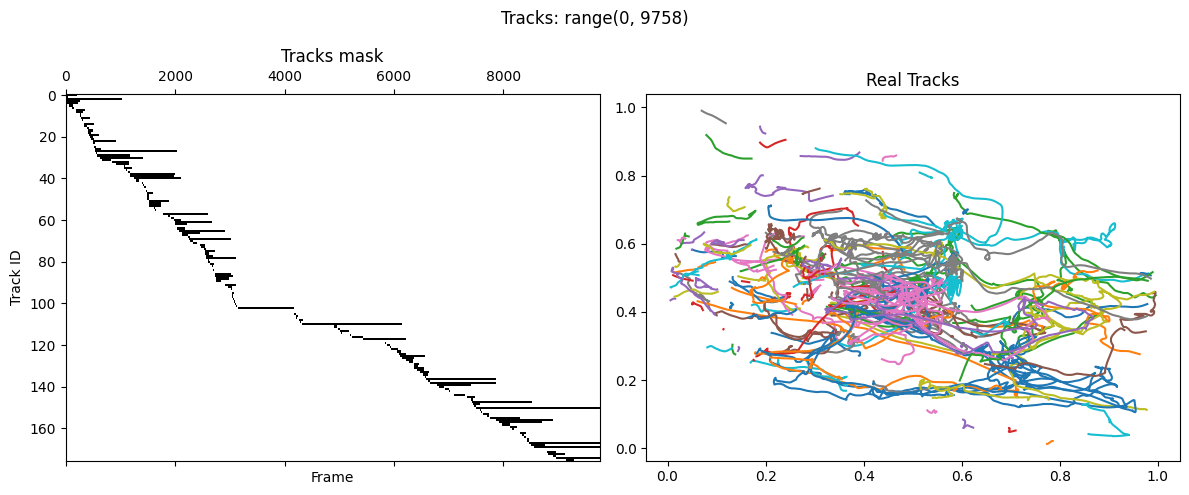

In [29]:
frame_rng = range(max_frame_id)
plot_tracks(all_tracks[...,frame_rng, :],
            all_tracks_mask[...,frame_rng],
            title=f"Tracks: {frame_rng}"
)

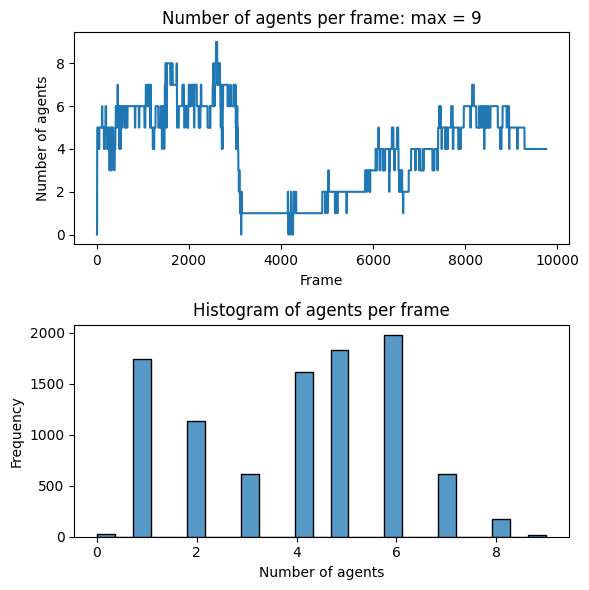

In [30]:
# max. number of agents in a frame
max_agents_per_frame = all_tracks_mask.sum(dim=0).max()
agents_per_frame = all_tracks_mask.sum(dim=0)
fig, ax = plt.subplots(2,1, figsize=(6, 6))
ax[0].plot(agents_per_frame)
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("Number of agents")
ax[0].set_title(f"Number of agents per frame: max = {max_agents_per_frame}")

sns.histplot(agents_per_frame, ax=ax[1])
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"Histogram of agents per frame")

plt.tight_layout()
plt.show()
# split into shorter tracks and stack into a dataset

### Attempt 1 - sliding windows of large size (similar to "files")

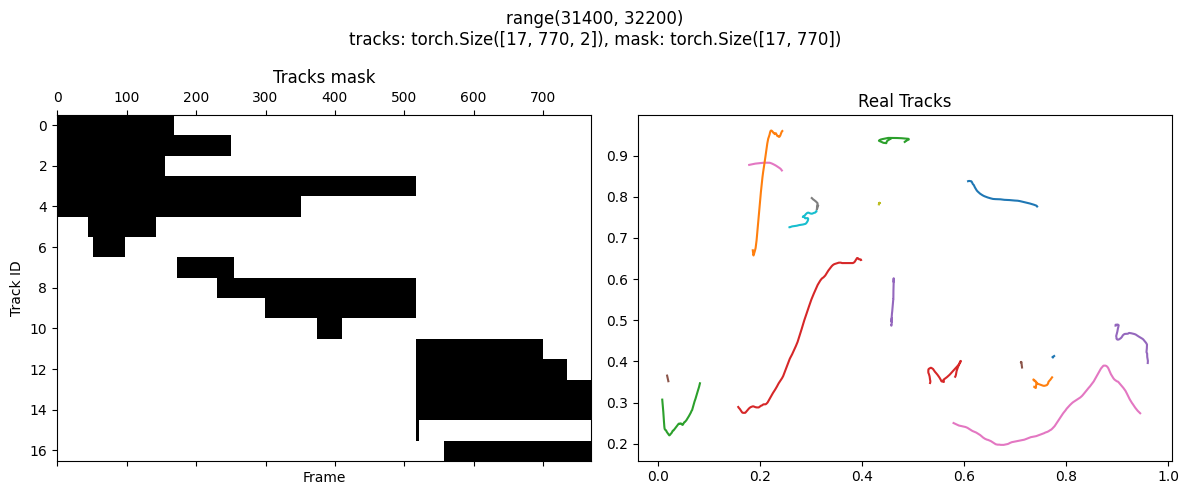

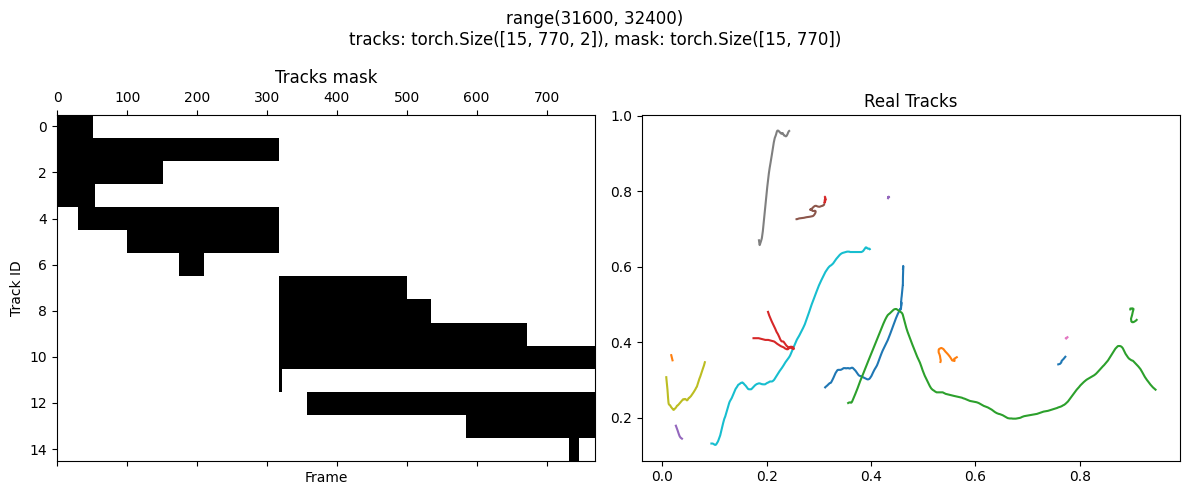

In [14]:
frame_window = 800
window_step = 200

for i in range(0, max_frame_id-frame_window, window_step)[-3:-1]:
    frame_rng = range(i, i + frame_window)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final,
                title=f"{frame_rng}\ntracks: {tracks_window.shape}, mask: {mask_window_final.shape}")


### Attempt 2 - constant #agents chunks

In [25]:
MIN_TRACK_LENGTH = 10

n_agents: 2, #chunks: 13, unique chunk_lengths: tensor([ 12,  16,  18,  21,  23,  36,  45,  63, 117, 132, 193, 
397])

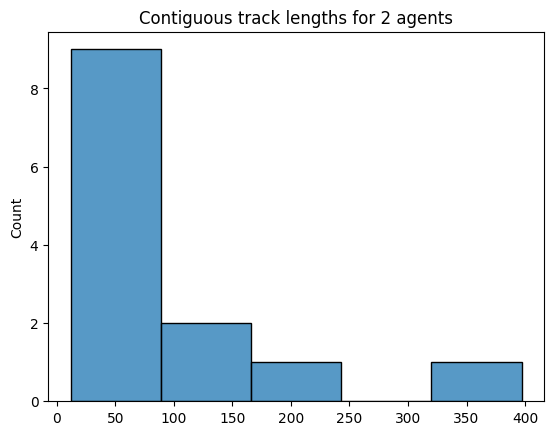

n_agents: 3, #chunks: 14, unique chunk_lengths: tensor([ 12,  13,  16,  17,  20,  32,  42,  44,  52,  56, 117])

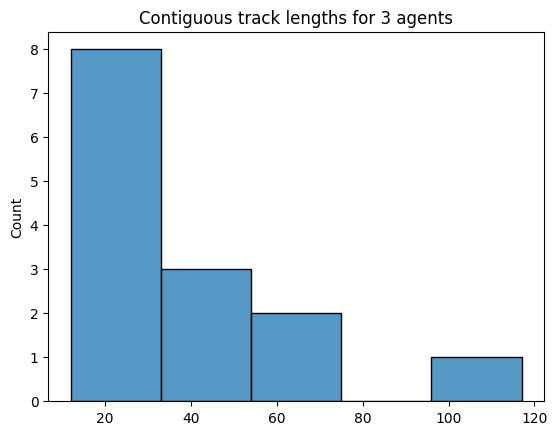

n_agents: 4, #chunks: 23, unique chunk_lengths: tensor([ 12,  13,  16,  17,  18,  20,  21,  23,  29,  33,  34,  42,
43,  48,
         57,  66,  76,  85,  89, 189, 473])

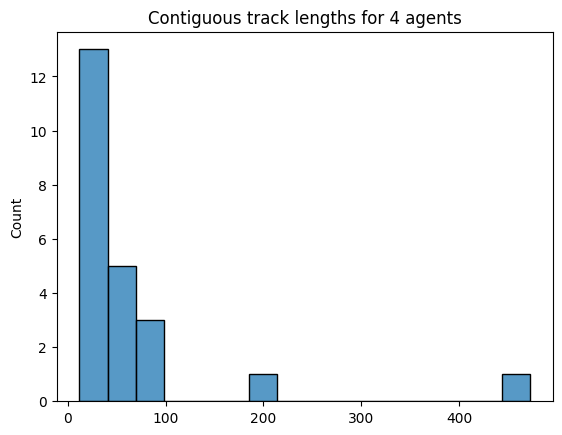

n_agents: 5, #chunks: 41, unique chunk_lengths: tensor([ 12,  14,  15,  16,  18,  20,  21,  22,  23,  27,  33,  34,
36,  37,
         38,  39,  47,  48,  51,  57,  58,  61,  69,  71, 109, 148, 170])

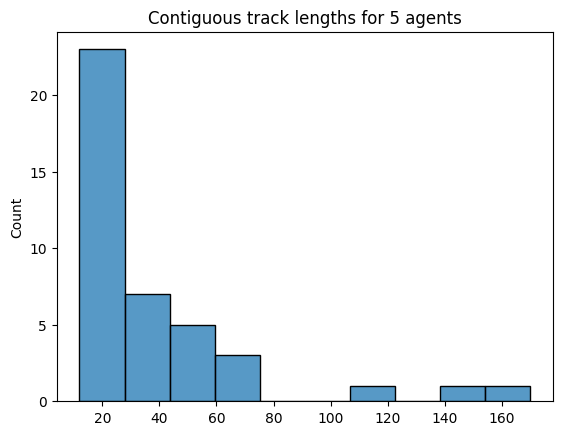

n_agents: 6, #chunks: 30, unique chunk_lengths: tensor([ 14,  17,  18,  19,  22,  27,  28,  29,  32,  34,  35,  41,
45,  46,
         50,  52,  55,  58,  61,  76,  77,  89, 110, 143, 159, 160])

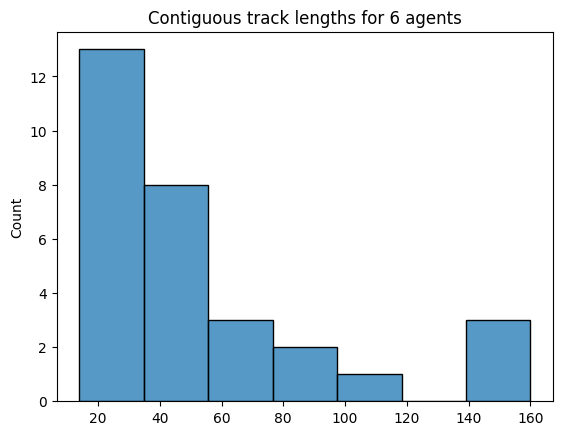

n_agents: 7, #chunks: 13, unique chunk_lengths: tensor([12, 14, 15, 18, 23, 26, 27, 36, 39, 44, 51, 85, 97])

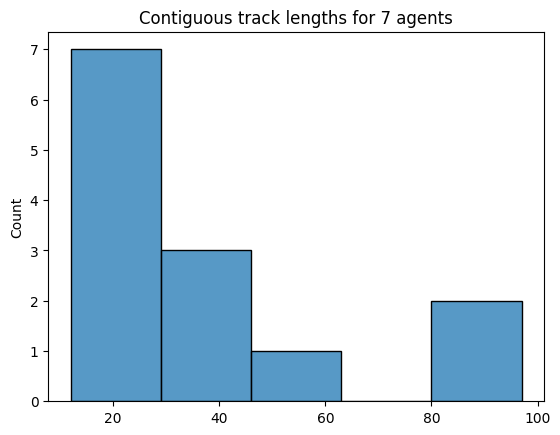

n_agents: 8, #chunks: 5, unique chunk_lengths: tensor([13, 20, 24, 25, 70])

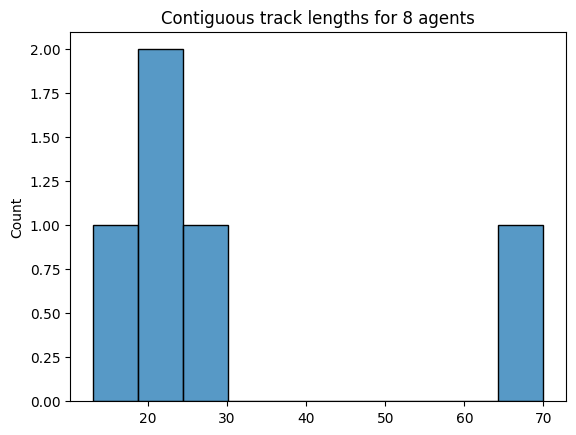

No chunks for 9 agents

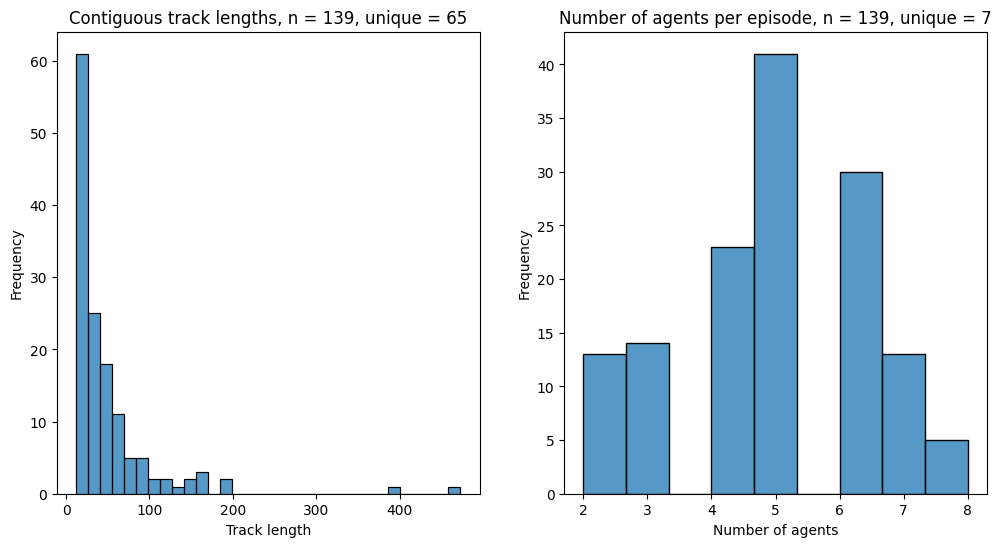

In [31]:
chunks_per_agent = {}
all_chunk_lengths = []
all_agents_per_episode = []
def count_unique_agents(frame_rng):
    return real_data[real_data.frame.isin(frame_rng)].track_id.nunique()

for n_agents in agents_per_frame.unique():
    if n_agents < 2:
        continue
    frame_indices = torch.where(agents_per_frame == n_agents)[0]
    chunks = []
    chunk_start = frame_indices[0]
    prev_chunk_frame = frame_indices[0]
    
    def filter_track(frame_rng):
        return (count_unique_agents(frame_rng) == n_agents) and (frame_rng[-1] - frame_rng[0] > MIN_TRACK_LENGTH)
    
    for frame in frame_indices[1:]:
        if frame == prev_chunk_frame + 1:
            prev_chunk_frame = frame
        else:
            if filter_track(range(chunk_start, prev_chunk_frame+1)):
                chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
                all_agents_per_episode.append(n_agents)
            chunk_start = frame
            prev_chunk_frame = frame
    if filter_track(range(chunk_start, prev_chunk_frame+1)):
        chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
        all_agents_per_episode.append(n_agents)
    if len(chunks) > 0:
        chunk_lengths = []
        for chunk in chunks:
            assert agents_per_frame[chunk[0]:chunk[1]+1].unique() == torch.tensor([n_agents]), f"{n_agents}: {chunk} "
            chunk_lengths.append(chunk[1] - chunk[0] + 1)
        chunk_lengths = torch.tensor(chunk_lengths)
        all_chunk_lengths.append(chunk_lengths)
        print(f"n_agents: {n_agents}, #chunks: {len(chunks)}, unique chunk_lengths: {chunk_lengths.unique()}")

        chunks_per_agent[n_agents] = chunks

        plt.figure()
        sns.histplot(chunk_lengths)
        plt.title(f"Contiguous track lengths for {n_agents} agents")
        plt.show()
    else:
        print(f"[red][bold]No chunks for {n_agents} agents[/bold][/red]")
all_chunk_lengths = torch.cat(all_chunk_lengths)
all_agents_per_episode = torch.tensor(all_agents_per_episode)
fig, ax = plt.subplots(1,2, figsize=(12, 6))
sns.histplot(all_chunk_lengths, ax=ax[0])
ax[0].set_title(f"Contiguous track lengths, n = {len(all_chunk_lengths)}, unique = {len(all_chunk_lengths.unique())}")
ax[0].set_xlabel("Track length")
ax[0].set_ylabel("Frequency")
sns.histplot(all_agents_per_episode, ax=ax[1])
ax[1].set_title(f"Number of agents per episode, n = {len(all_agents_per_episode)}, unique = {len(all_agents_per_episode.unique())}")
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
plt.show()


In [32]:
all_tracks_list = []
for agent, chunks in chunks_per_agent.items():
    print(f"agent: {agent}, #chunks: {len(chunks)}")
    for chunk in tqdm(chunks):
        frame_rng = range(chunk[0], chunk[1]+1)
        mask = torch.zeros_like(all_tracks_mask)
        mask[:,frame_rng]  = 1
        mask_window = mask & all_tracks_mask
        row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
        col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
        tracks_window = all_tracks[row_indices,col_indices,:]
        mask_window_final = mask_window[row_indices,col_indices]
        all_tracks_list.append((tracks_window, mask_window_final))
    
print(f"all_tracks_list: {len(all_tracks_list)}")

agent: 2, #chunks: 13

  0%|          | 0/13 [00:00<?, ?it/s]

agent: 3, #chunks: 14

  0%|          | 0/14 [00:00<?, ?it/s]

agent: 4, #chunks: 23

  0%|          | 0/23 [00:00<?, ?it/s]

agent: 5, #chunks: 41

  0%|          | 0/41 [00:00<?, ?it/s]

agent: 6, #chunks: 30

  0%|          | 0/30 [00:00<?, ?it/s]

agent: 7, #chunks: 13

  0%|          | 0/13 [00:00<?, ?it/s]

agent: 8, #chunks: 5

  0%|          | 0/5 [00:00<?, ?it/s]

all_tracks_list: 139

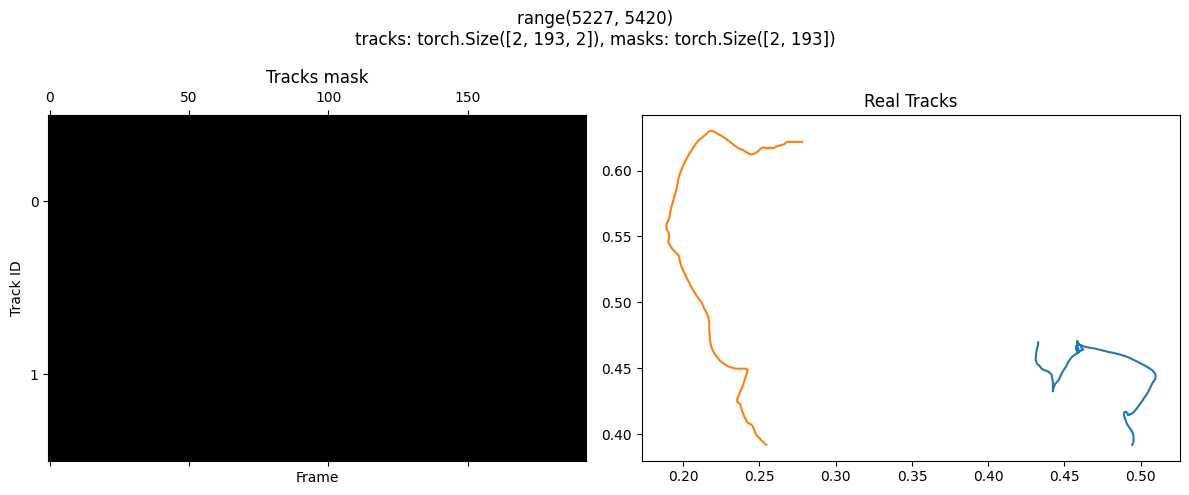

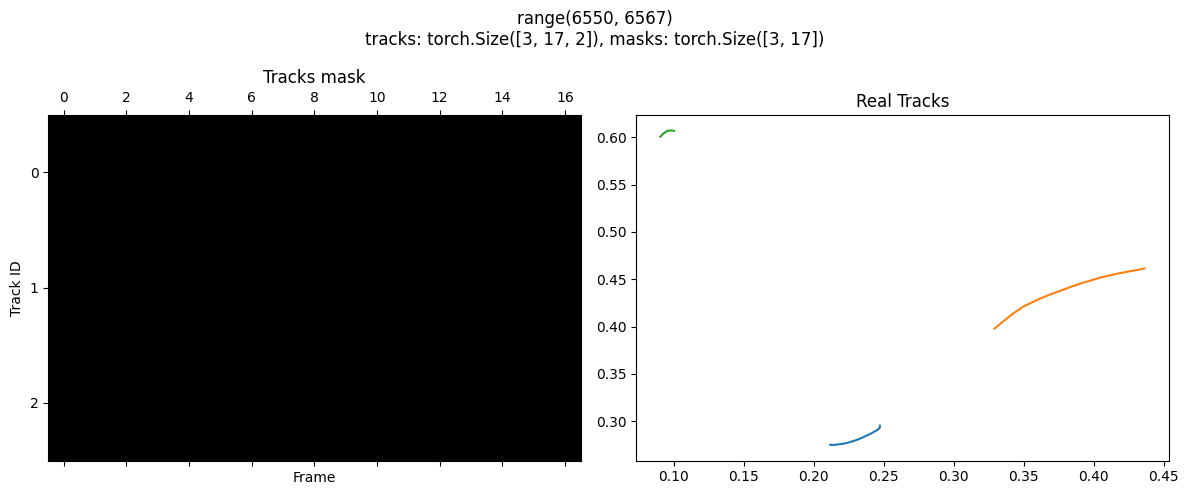

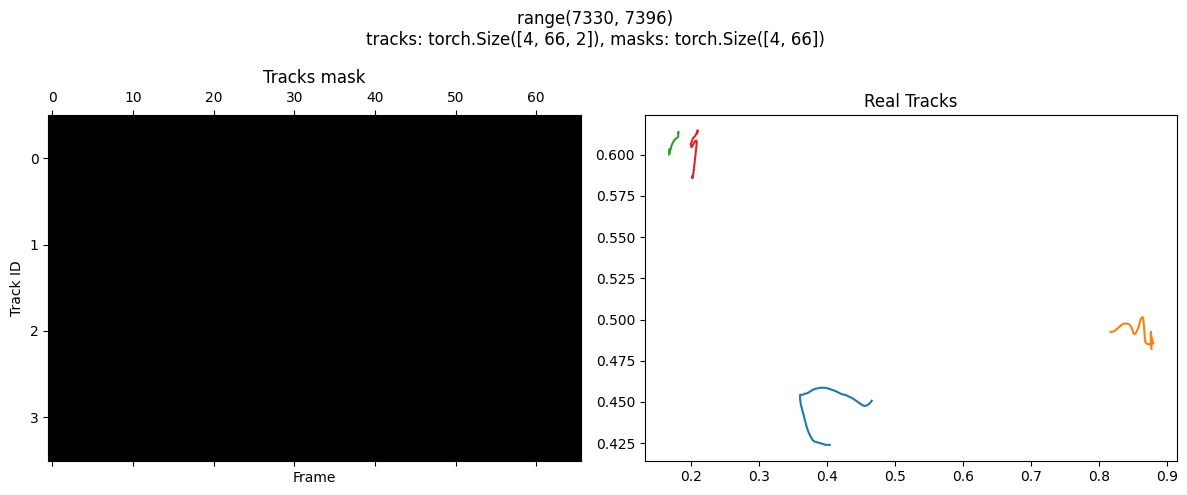

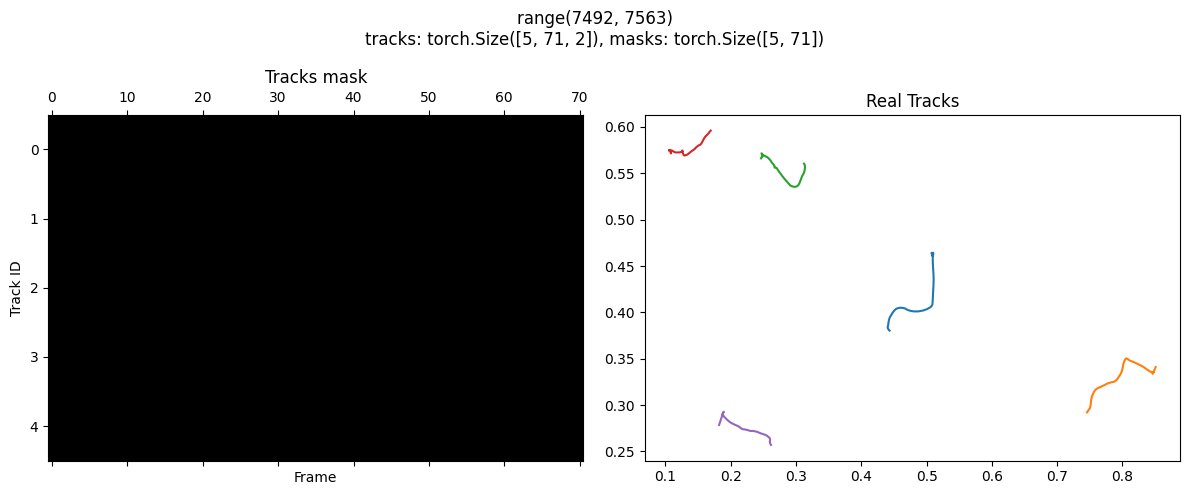

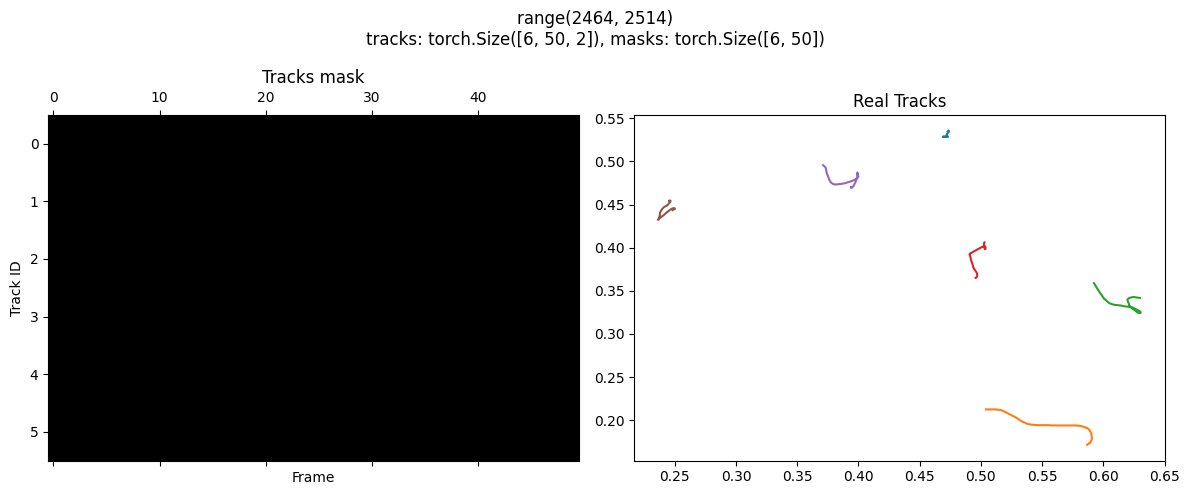

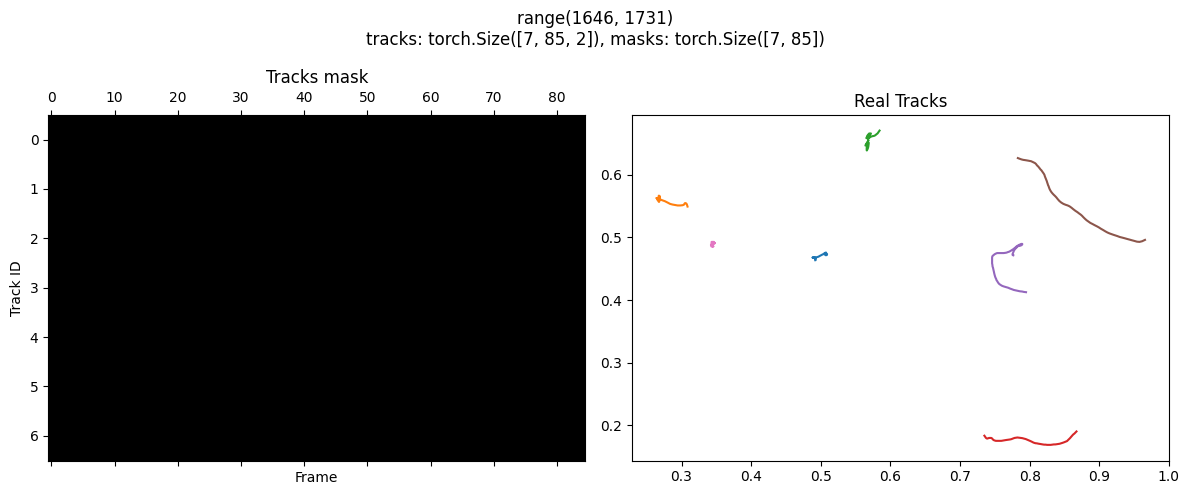

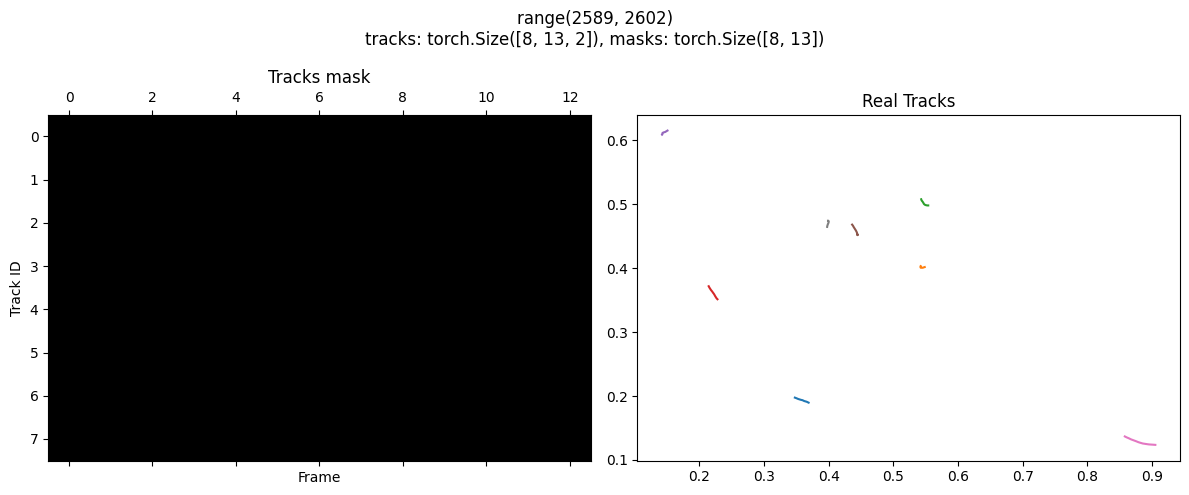

In [33]:
for agent, chunks in chunks_per_agent.items():
    # select random chunk (we have already filtered by length)
    chunk = chunks[torch.randint(0, len(chunks), (1,))]
    frame_rng = range(chunk[0], chunk[1]+1)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final, title=f"{frame_rng}\ntracks: {tracks_window.shape}, masks: {mask_window_final.shape}")


In [34]:
class RealTracksMaskedDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            pair[0].permute(1,0,2), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long),
            pair[1].permute(1,0) # mask
        )

all_tracks_dataset = RealTracksMaskedDataset(all_tracks_list)
print(f"all_tracks_dataset: {len(all_tracks_dataset)}")
track, species, mask = all_tracks_dataset[0]
print(f"track.shape: {track.shape}, species.shape: {species.shape}, mask.shape: {mask.shape}")


all_tracks_dataset: 139

track.shape: torch.Size([23, 2, 2]), species.shape: torch.Size([2]), mask.shape: torch.Size([23, 2])

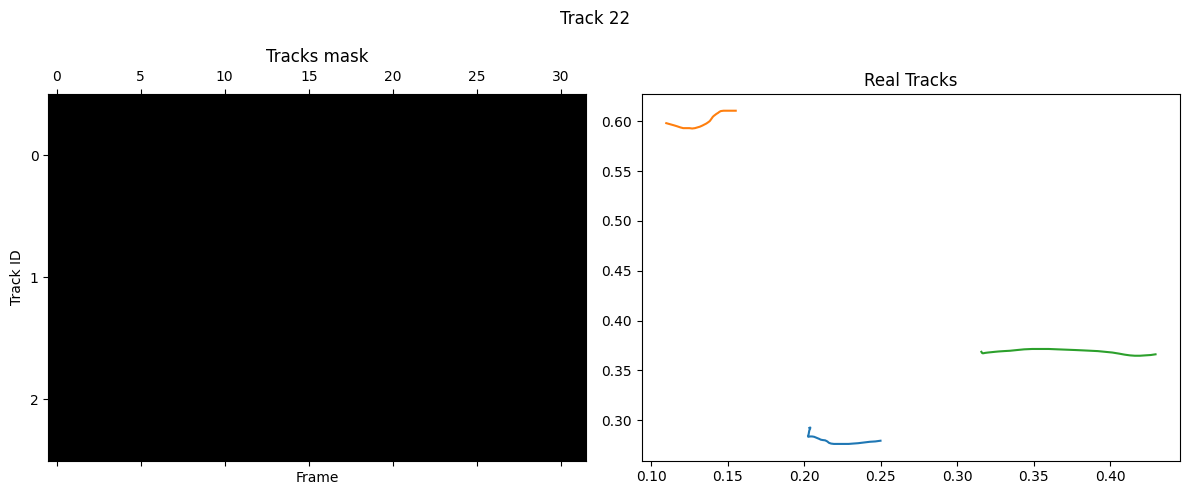

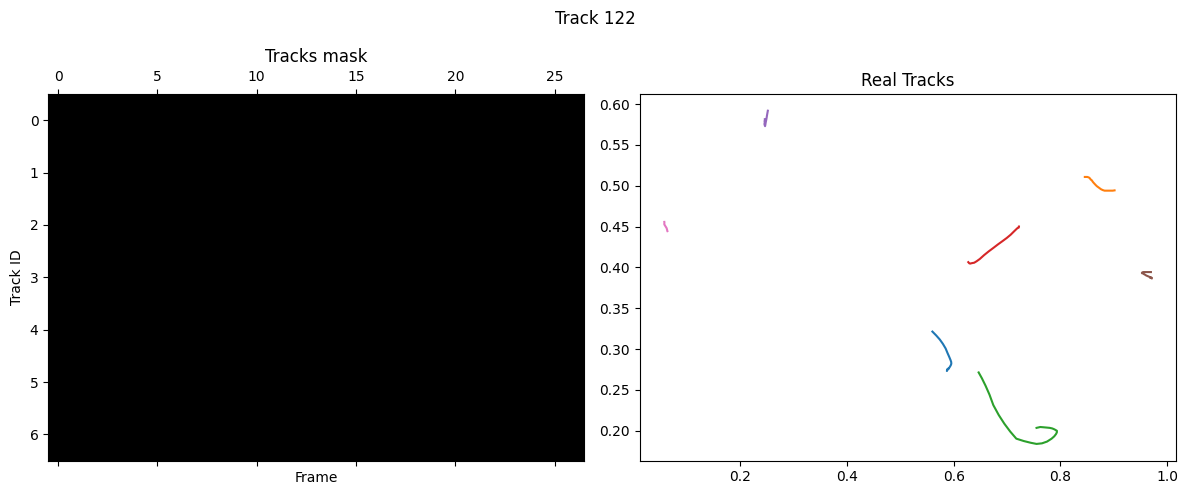

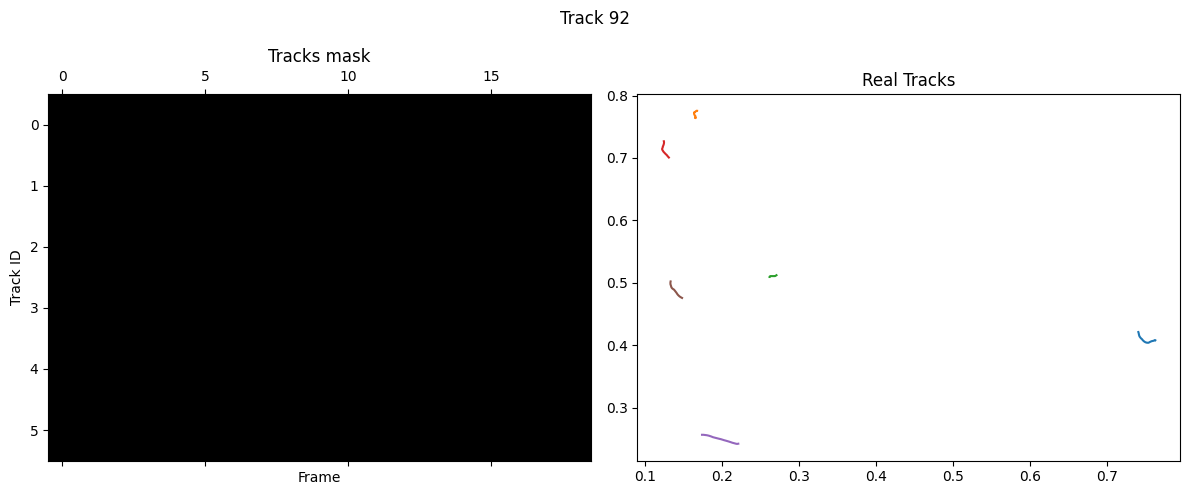

In [35]:
indices = torch.randint(0, len(all_tracks_dataset), (3,))
for i in indices:
    track, _, mask = all_tracks_dataset[i]
    plot_tracks(track.permute(1,0,2), mask.permute(1,0), title=f"Track {i}")


## The GNN

In [36]:
train_size = 0.5
do_pretrain = False # if True, load pre-trained GNN
do_train = True # if True, train GNN on real tracks 
# if both are False, will run an un-trained GNN


### Convert dataset to GNN format

In [37]:
class RealTracksGNNDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            torch.as_tensor(pair[0].permute(1,0,2), dtype=torch.float32), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long), # species
        )

all_tracks_gnn_dataset = RealTracksGNNDataset(all_tracks_list)


test_loader, train_loader = dataset2testloader(
    all_tracks_gnn_dataset,
    batch_size=1,
    return_train=True,
    device=torch.device("cpu"),
    train_size=train_size
)

logger.info(f"train_loader: {len(train_loader)}, test_loader: {len(test_loader)}")

2025-09-04 19:10:34.688 | INFO     | __main__:<module>:26 - train_loader: 69, test_loader: 70


### Create GNN, optional: load pre-trained GNN for fine-tuning

In [38]:
# load pre-trained GNN
logger.info("Loading pre-trained GNN")
model_name = "vpluspplus_a"
model_rel_path = "trained_models/boid_single_species_basic/trained_models/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2"
model_pretrained, mdl_spec, mdl_train_spec = load_model(model_name, ".", model_rel_path)


2025-09-04 19:10:36.333 | INFO     | __main__:<module>:2 - Loading pre-trained GNN
2025-09-04 19:10:36.334 | DEBUG    | collab_env.gnn.gnn:load_model:990 - Loaded model spec.
2025-09-04 19:10:36.335 | DEBUG    | collab_env.gnn.gnn:load_model:995 - Loaded training spec.
2025-09-04 19:10:36.384 | DEBUG    | collab_env.gnn.gnn:load_model:1016 - Loaded model.


In [39]:
if do_pretrain:
    logger.info("Initializing with pre-trained GNN")
    model_trained = model_pretrained
else:
    logger.info("Training GNN from scratch")

    in_node_dim = 19 # no food
    heads = 1

    model_spec = {
        "model_name": "vpluspplus_a",
        "node_feature_function": "vel_plus_pos_plus",
        "node_prediction": "acc",
        "prediction_integration": "Euler",
        "input_differentiation": "finite",
        "in_node_dim": in_node_dim,
        "start_frame": 3,
        "heads": heads
    }

    model_trained = GNN(**model_spec)    

2025-09-04 19:10:37.717 | INFO     | __main__:<module>:5 - Training GNN from scratch


### Train GNN

2025-09-04 19:10:39.573 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:646 - Starting epoch 1/50
2025-09-04 19:10:39.574 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 1/69
2025-09-04 19:10:39.611 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 2/69
2025-09-04 19:10:39.627 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 3/69
2025-09-04 19:10:39.713 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 4/69
2025-09-04 19:10:39.754 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 5/69
2025-09-04 19:10:39.768 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 6/69
2025-09-04 19:10:39.868 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 7/69
2025-09-04 19:10:39.886 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/50 | Processing batch 8/6

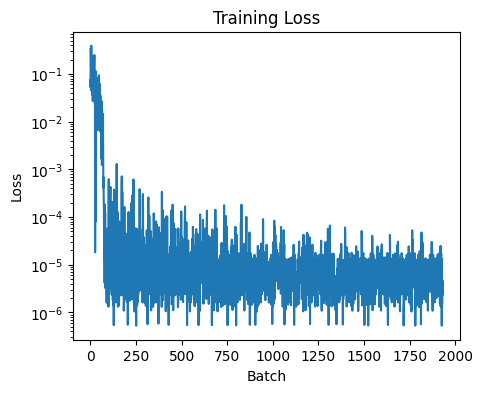

In [40]:
if do_train:

    seed  = 0

    torch.manual_seed(seed)
    np.random.seed(seed)

    train_losses, trained_model, _ = train_rules_gnn(
        model_trained,
        train_loader,
        species_dim = 1,
        epochs = 50,
        training = True,
        sigma = 0.005,
        device = device,
        lr = 1e-5,
        val_dataloader = test_loader,
        early_stopping_patience = 3,
        min_delta = 1e-7
    )

    #  save model
    model_output = expand_path(
        f"trained_models/{Path(real_data_fn).stem}.pt",
        get_project_root(),
    )
    torch.save(model_trained.state_dict(), model_output)
    logger.info(f"Model saved to {model_output}.")

    plt.figure(figsize=(5, 4))
    plt.semilogy(train_losses.ravel())
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

### Generate rollouts

In [41]:
rollout = 5
total_rollout = 200
labels = ["pretrained", "trained"]
rollout_results = {}
for model, label in zip([model_pretrained, model_trained], labels):
    _, _, rollout_results[label] = train_rules_gnn(
        model,
        test_loader,
        species_dim = 1,
        epochs = 1,
        lr = None,
        training = False,
        device = device,
        rollout = rollout,
        total_rollout = total_rollout,
        collect_debug=True,  
        val_dataloader=None
    )

    rollout_path =expand_path(
        f"trained_models/{Path(real_data_fn).stem}_{label}_rollout_{rollout}_frames_{total_rollout}.pt",
        get_project_root(),
    )
    with open(rollout_path, "wb") as f: # 'wb' for write binary
        pickle.dump(rollout_results[label], f)
    logger.info(f"Rollout saved to {rollout_path}.")


2025-09-04 19:12:40.226 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:639 - rolling out...
2025-09-04 19:12:40.226 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:646 - Starting epoch 1/1
2025-09-04 19:12:40.227 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 1/70
2025-09-04 19:12:40.245 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 2/70
2025-09-04 19:12:40.252 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 3/70
2025-09-04 19:12:40.261 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 4/70
2025-09-04 19:12:40.304 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 5/70
2025-09-04 19:12:40.331 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 6/70
2025-09-04 19:12:40.343 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:654 - Epoch 1/1 | Processing batch 7/70
2025-09-04 19:12:40.351 | 

### Visualize rollouts

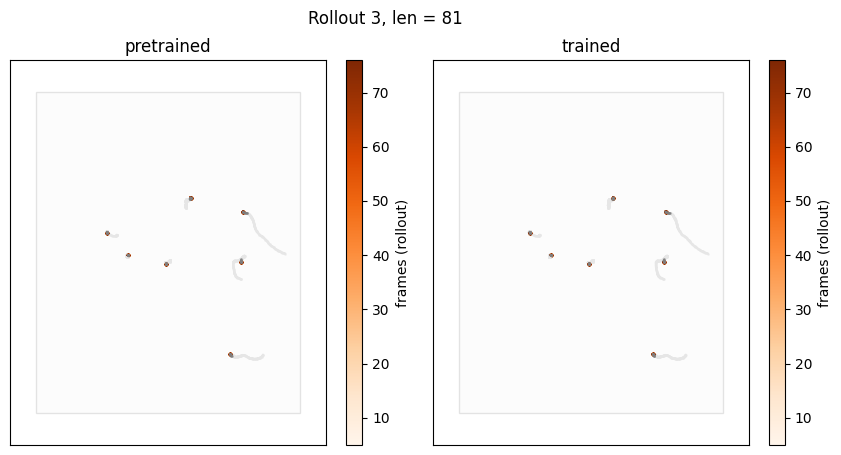

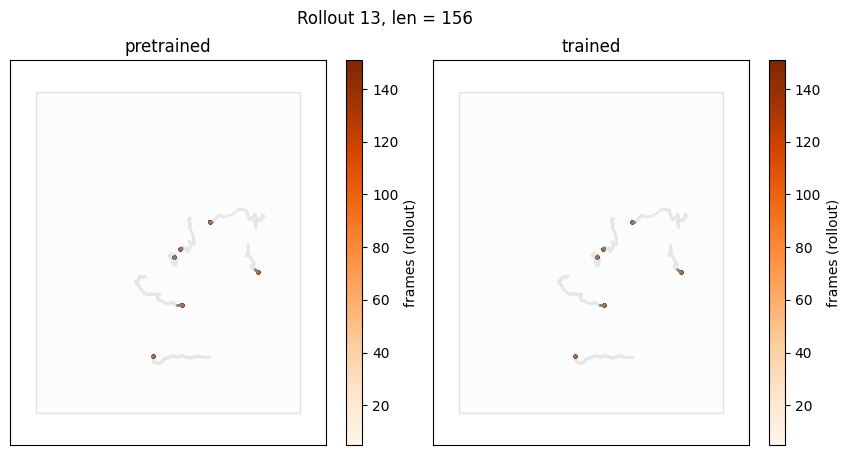

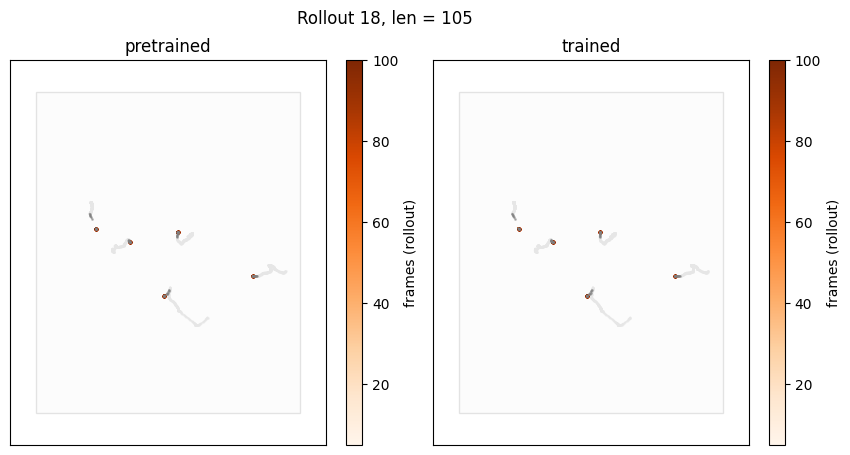

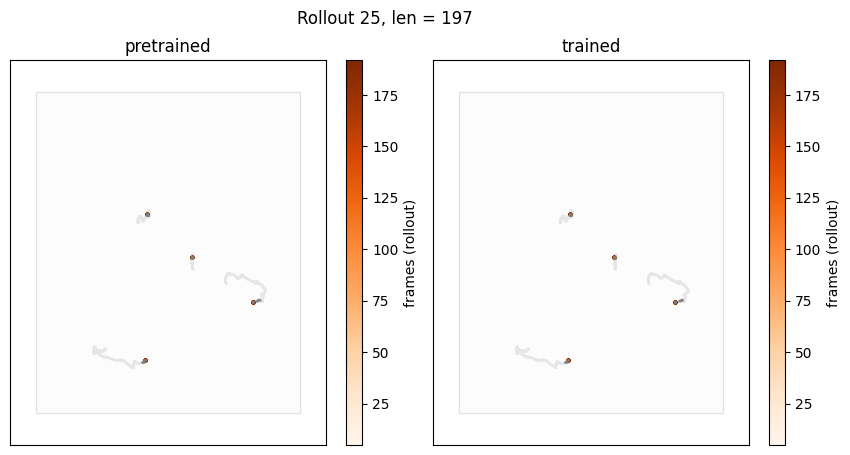

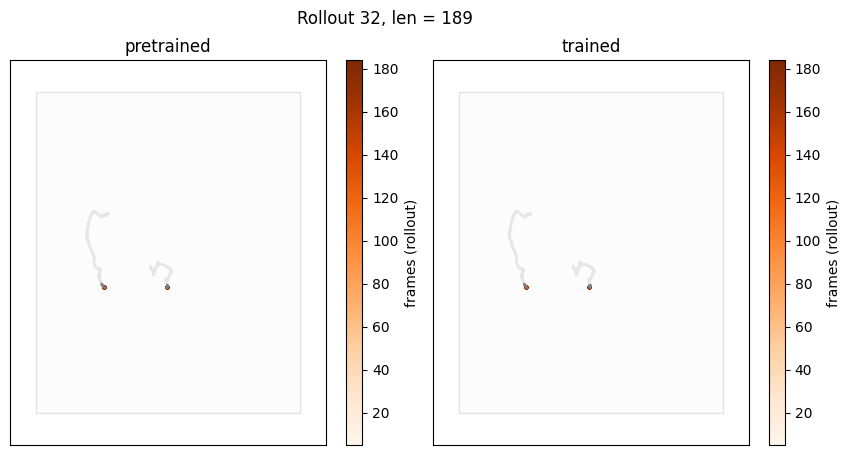

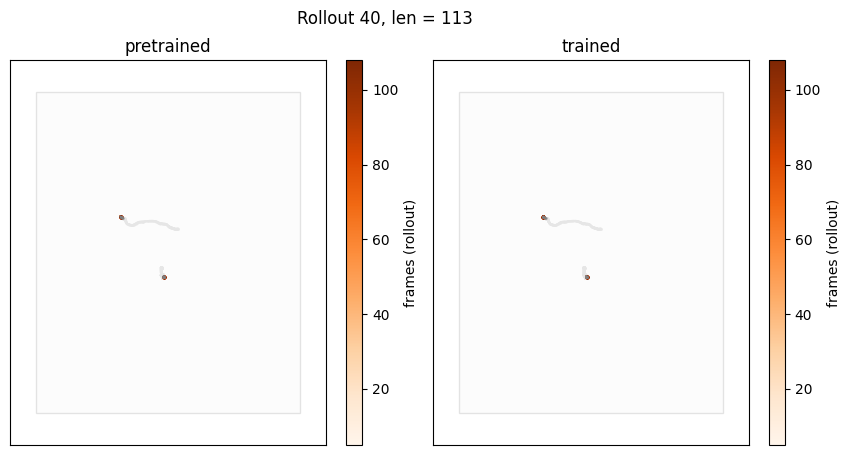

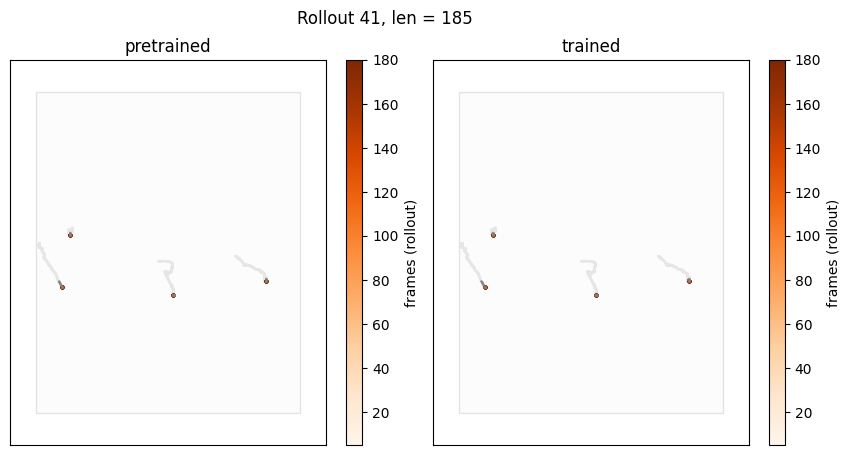

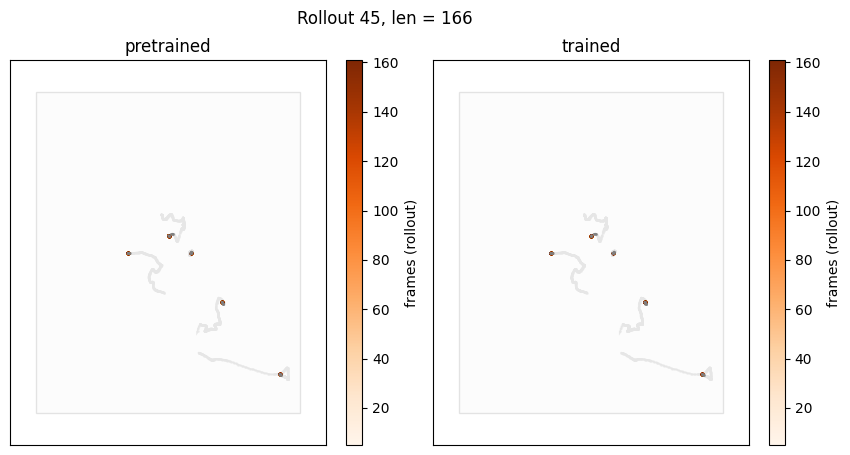

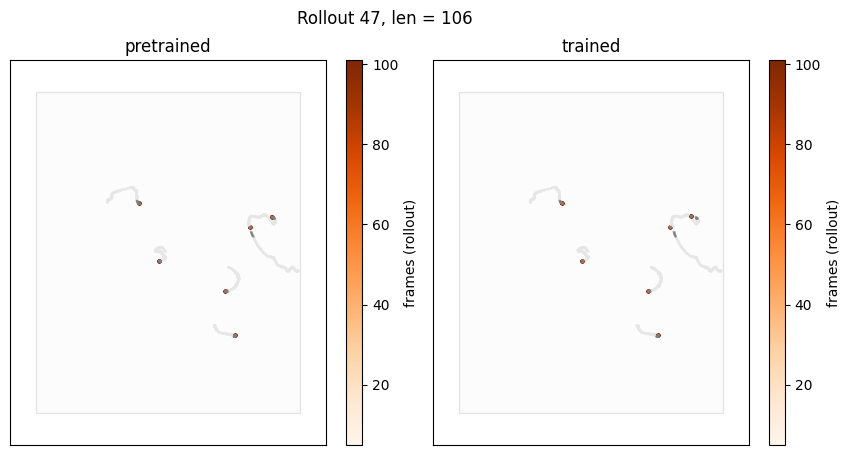

In [43]:
EPISODE_LENGTH_RANGE = [80, 200]
n_files = len(rollout_results["pretrained"][0])
for file_id in range(n_files):
    actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results["pretrained"],
                    file_id = file_id, epoch_num = 0)
    actual_track_len = actual_pos.shape[1]
    if actual_track_len < EPISODE_LENGTH_RANGE[0] or actual_track_len > EPISODE_LENGTH_RANGE[1]:
        continue
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    for i, (label, rollout_result) in enumerate(rollout_results.items()):
        if i > 0:
            actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                            rollout_result,
                            file_id = file_id, epoch_num = 0)

        assert actual_pos.shape[1] == actual_track_len

        starting_frame = 0
        rollout_starting_frame = rollout
        ending_frame = actual_track_len - rollout_starting_frame
        # fig, ax = plt.subplots(figsize=(6,5))
        _ = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                        starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                                    ending_frame = ending_frame, fig = fig,ax = axs[i])
        axs[i].set_title(label)
    plt.suptitle(f"Rollout {file_id}, len = {actual_track_len}")
    # plt.suptitle(f"Rollout {file_id}")
    plt.show()
